In [1]:
"""Here I would like to look at stock price data for Progressive Insurance, ticket PGR

A simple look at the stock price, returns, and a forecast using ARIMA, following documentation or
an article that I can figure out.

Let's get started

**Some ideas and code will be taken from this Kaggle article:
    https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima
"""

"Here I would like to look at stock price data for Progressive Insurance, ticket PGR\n\nA simple look at the stock price, returns, and a forecast using ARIMA, following documentation or\nan article that I can figure out.\n\nLet's get started\n\n**Some ideas and code will be taken from this Kaggle article:\n    https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima\n"

In [2]:
#Necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


#Time series analysis and modeling tools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

#Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#Download the data
pgr = yf.download('PGR', start = '2018-01-1', ends = '2022-01-1')
print(type(pgr))

#Basic data inspection
print(pgr.head())
print(pgr.shape)
print(pgr.info())
print(pgr.describe())

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2018-01-02  56.459999  56.459999  55.070000  55.360001  46.956570  2715500
2018-01-03  55.320000  55.560001  54.860001  55.330002  46.931129  3247300
2018-01-04  55.430000  55.799999  55.099998  55.320000  46.922642  2573300
2018-01-05  55.439999  55.590000  54.869999  55.529999  47.100761  3264800
2018-01-08  55.610001  55.820000  55.320000  55.700001  47.244961  3075600
(1048, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048 entries, 2018-01-02 to 2022-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1048 non-null   float64
 1   High       1048 non-null   float64
 2   Low        1048 non-null   float64
 3   Close      1048 non-null   fl

In [4]:
#Create adjusted close df and returns df

pgr_close = pgr['Adj Close']

pgr_returns = pgr_close.pct_change().dropna()
print(pgr_returns.describe())


count    1047.000000
mean        0.000892
std         0.016700
min        -0.094846
25%        -0.007144
50%         0.001093
75%         0.009207
max         0.121373
Name: Adj Close, dtype: float64


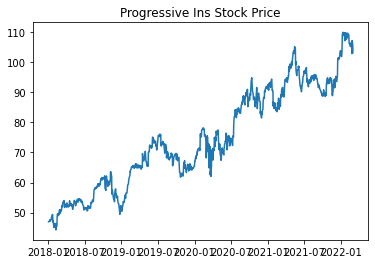

In [5]:
#Let's take a look at how PGR has changed over time
plt.plot(pgr.index, pgr_close)
plt.title('Progressive Ins Stock Price')
plt.show()


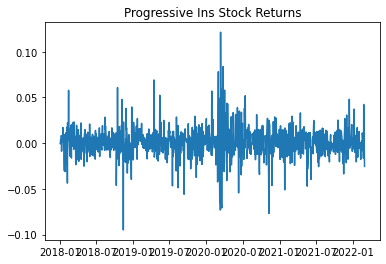

In [6]:
#And how its returns have looked over time
plt.plot(pgr_returns.index, pgr_returns)
plt.title('Progressive Ins Stock Returns')
plt.show()

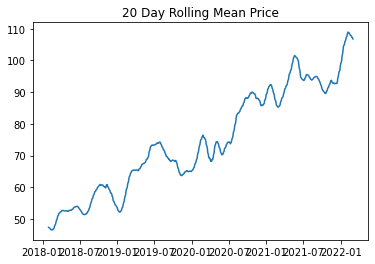

In [7]:
#20 day Rolling Mean for both pgr['Adj Close'] and pgr_returns

#Adj Close
plt.plot(pgr.index, pgr_close.rolling(window = 20).mean())
plt.title('20 Day Rolling Mean Price')
plt.show()

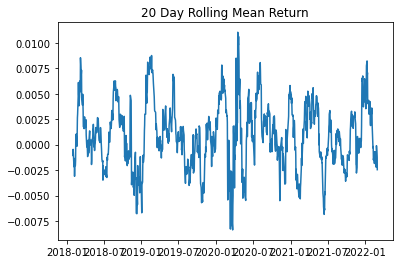

In [8]:
#Returns
plt.plot(pgr_returns.index, pgr_returns.rolling(window = 20).mean())
plt.title('20 Day Rolling Mean Return')
plt.show()

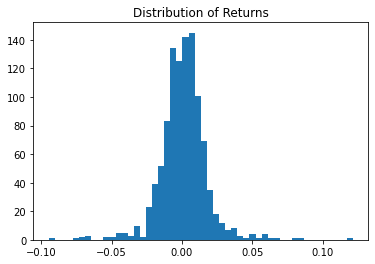

In [9]:
#Histogram of returns
plt.hist(pgr_returns, bins = 50)
plt.title("Distribution of Returns")
plt.show()

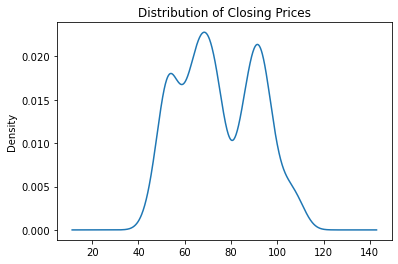

In [10]:
#Distribution of PGR Price
pgr_close.plot(kind = 'kde')
plt.title('Distribution of Closing Prices')
plt.show()

In [11]:
#Now it's time for a stationarity test
#Eyeballing it, the closing prices are probably not stationary, while the returns might be

#ADF Test and a function for it are defined in the statsmodels documentation
#But here, we will use the function that Kaggle defined
#Kaggle uses a 12 period moving average, we will use a parameter 'size' to choose

def test_stationarity(timeseries, size):
    #Calculating and plotting rolling statistics
    rolmean = timeseries.rolling(window = size).mean()
    rolstd = timeseries.rolling(window = size).std()
    
    
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best')
    plt.title(f'Rolling {size} Day Mean and Std')
    plt.show(block = False)
    
    #ADF test
    print("Results of ADF Test: ")
    
    adft = adfuller(timeseries, autolag = 'AIC')
    #The adfuller() function does not format the output, that's on us
    #The documentation offers a way to do this, here we will follow Kaggle
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. Lags Used', 'No. Observations Used'])
    for key, values in adft[4].items():
        output['Critical Values (%s)'%key] = values
    print(output)
    
    #Returns nothing

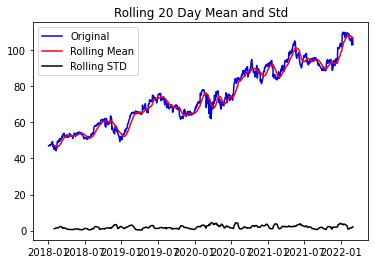

Results of ADF Test: 
Test Statistics            -0.864190
p-value                     0.799536
No. Lags Used              11.000000
No. Observations Used    1036.000000
Critical Values (1%)       -3.436678
Critical Values (5%)       -2.864334
Critical Values (10%)      -2.568258
dtype: float64


In [12]:
test_stationarity(pgr_close, 20)

#The p-value is far higher than the significance level 0.05
#The closing price series is *not* stationary (We cannot reject the null hypothesis)

#Use this code to see if the pgr_returns are stationary or not!
#test_stationarity(pgr_returns, size = 20)

<ipython-input-13-63ed6dad9a08>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(pgr_close, model = 'multiplicative', freq = 30)


<Figure size 432x288 with 0 Axes>

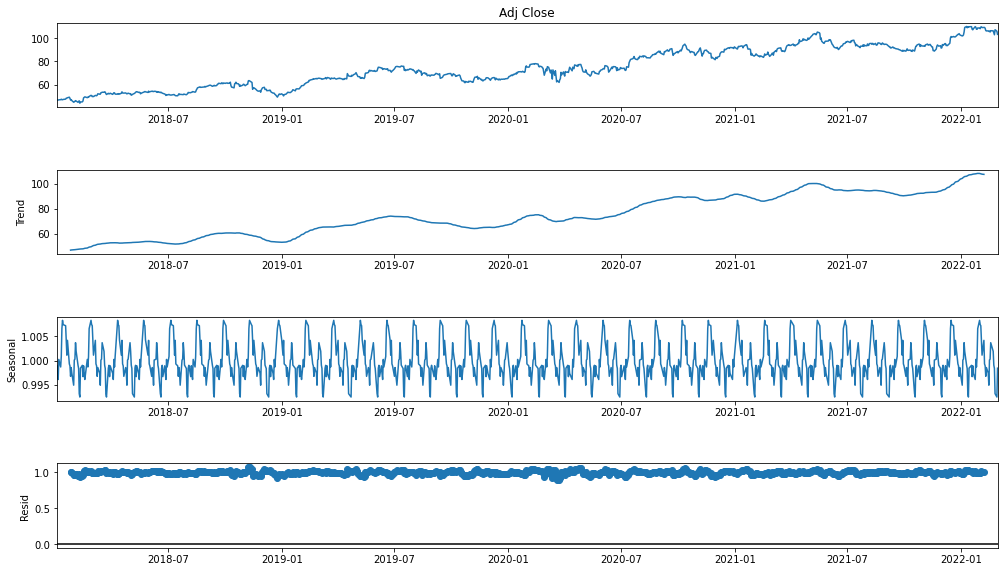

In [13]:
#To get the closing prices stationary, we need to decompose the series

decomp = seasonal_decompose(pgr_close, model = 'multiplicative', freq = 30)
#And plot
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(16, 9)

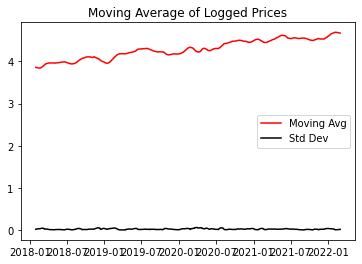

In [14]:
#One way to get a good model is to reduce the variance which can be done by 
#taking the log of the series

pgr_log = np.log(pgr_close)

moving_avg = pgr_log.rolling(window = 20).mean()
std_dev = pgr_log.rolling(window = 20).std()

plt.plot(moving_avg, color = 'red', label = 'Moving Avg')
plt.plot(std_dev, color = 'black', label = 'Std Dev')
plt.title("Moving Average of Logged Prices")
plt.legend(loc = 'best')
plt.show()

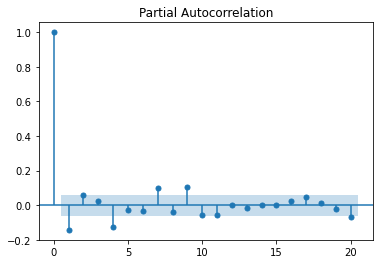

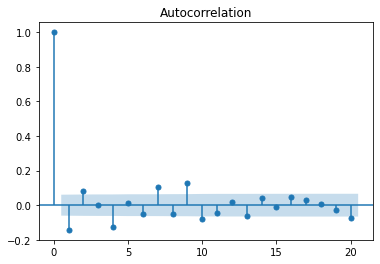

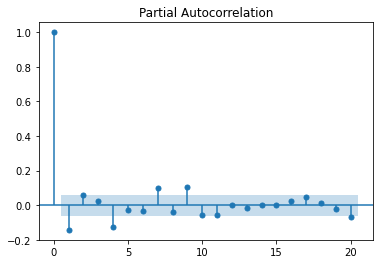

In [24]:
#Now we will examine acf and pacf plots
#Let's do so with a differenced series
sm.graphics.tsa.plot_acf(pgr_log.diff(1).dropna(), lags = 20)
sm.graphics.tsa.plot_pacf(pgr_log.diff(1).dropna(), lags = 20)

In [16]:
#Time for ARIMA, first things first: train test split
train, test = pgr_log[3:int(len(pgr_log)*0.9)], pgr_log[int(len(pgr_log)*0.9):]
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (940,)
Test shape:  (105,)


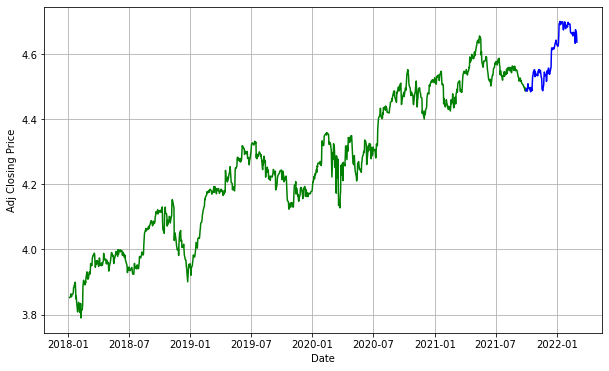

In [17]:
#Take a look at the split:
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.plot(train, color = 'green', label = 'Training Data')
plt.plot(test, color = 'blue', label = 'Testing Data')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6030.331, Time=0.03 sec


C:\Anaconda3\envs\fin_py\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (5) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5604.807, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5565.562, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5611.433, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3212.599, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-5609.979, Time=0.49 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2004.446, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5614.121, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2425.883, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5606.345, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5611.940, Time=0.67 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5612.437, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


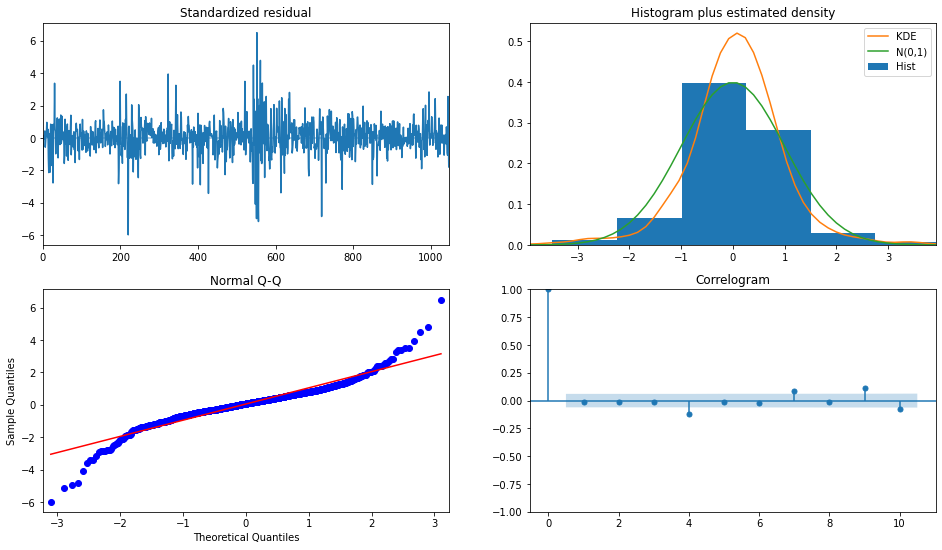

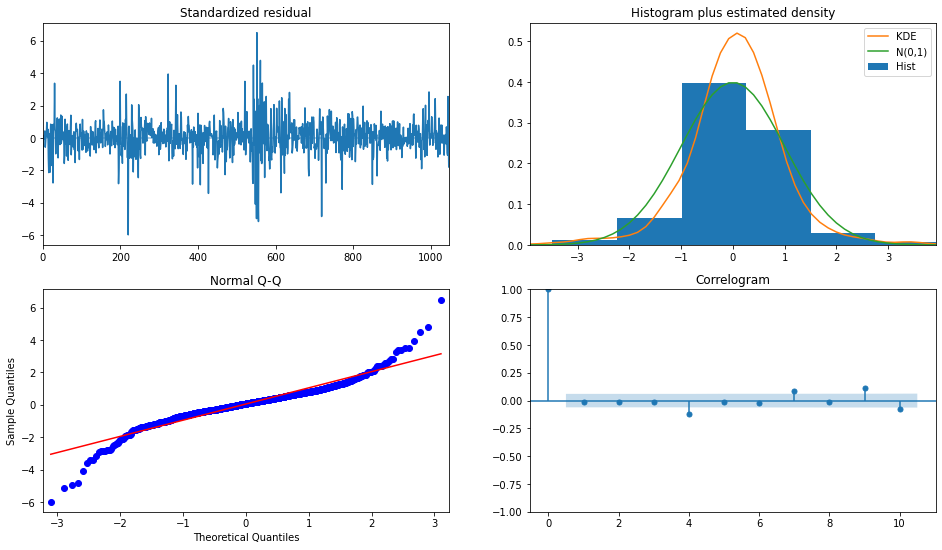

In [18]:
#We will start with auto.arima

pgr_autoarima = auto_arima(pgr_log, start_p = 0, start_q = 0, test = 'adf', 
                             max_p = 3, max_q = 3,
                             m = 5,
                             d = None,
                             seasonal = False,
                             start_P = 0,
                             D = 0,
                             trace = True,
                             error_action = 'ignore',
                             suppress_warnings = True,
                             stepwise = True)

print(pgr_autoarima.summary())
pgr_autoarima.plot_diagnostics(figsize = (16,9))

#From the summary, we see that (p,d,q) = (1,0,2) is optimal, interesting that d = 0

In [19]:
#Now let's build a model that we can use for forecasting

pgr_arima = ARIMA(train, order = (1,0,2))
fit = pgr_arima.fit(disp = -1)
print(fit.summary())

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  940
Model:                     ARMA(1, 2)   Log Likelihood                2505.424
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 01 Mar 2022   AIC                          -5000.848
Time:                        19:07:04   BIC                          -4976.619
Sample:                             0   HQIC                         -4991.612
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.2128      0.188     22.452      0.000       3.845       4.581
ar.L1.Adj Close     0.9980      0.002    530.599      0.000       0.994       1.002
ma.L1.Adj Close    -0.1374      

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

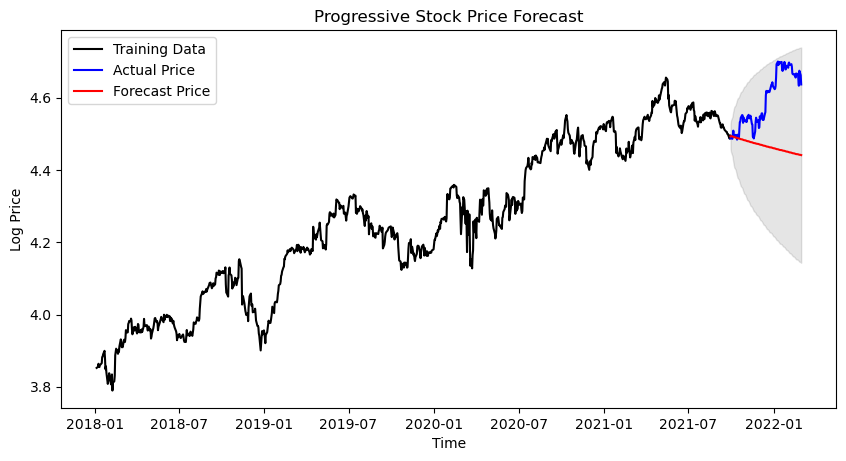

In [20]:
#Time to forecast

fc, se, conf_int = fit.forecast(test.shape[0], alpha = 0.05)

#We meed to do a little massaging in order to plot this
fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf_int[:, 0], index = test.index)
upper_series = pd.Series(conf_int[:, 1], index = test.index)

plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(train, color = 'black', label = 'Training Data')
plt.plot(test, color = 'blue', label = 'Actual Price')
plt.plot(fc_series, color = 'red', label = 'Forecast Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.10)
plt.title('Progressive Stock Price Forecast')
plt.xlabel('Time')
plt.ylabel('Log Price')
plt.legend(loc = 'best')
plt.show()

In [21]:
#From the graphic, this is a pretty terrible forecast

#Model Performance Metrics
mse = mean_squared_error(test, fc)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test, fc)
print('MAE: ' + str(mae))

rmse = np.sqrt(mean_squared_error(test, fc))
print('RMSE: ' + str(rmse))

mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: ' + str(mape))


#MAPE is a good metric for this kind of model
#And with a mape of 0.025, our model is 97.5% accurate over the next 105 days
#If you placed long-trades or investments in PGR based off this model, you would be glad
#If you shorted PGR based off this model, you might be disappointed

MSE: 0.023742176365730155
MAE: 0.12684244792679425
RMSE: 0.15408496476207584
MAPE: 0.02731537054882379
